In [1]:
import sympy as sp
sp.init_printing(long_frac_ratio=2)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./mpl_style")
import matplotlib.patches as patches
from IPython.display import display

import pylbo
from pylbo.utilities.debug import get_debug_coolingcurves

from panel_label import add_panel_label

In [2]:
slowlabel = r"$\omega_{slow}$"
alfvenlabel = r"$\omega_A$"
fastlabel = r"$\omega_{fast}$"
thermallabel = r"$\omega_{thermal}$"

xlabel = "Re($\omega$)"
ylabel = "Im($\omega$)"

In [3]:
rho1, vx1, vy1, vz1, T1, Ax1, Ax2, Ax3 = sp.symbols(
  "rho_1, v_{x1}, v_{y1}, v_{z1}, T_1, A_{x1}, A_{x2}, A_{x3}"
)
rho0, T0, gamma = sp.symbols("rho_0, T_0, gamma")
b0 = sp.symbols("B_0")
gmone = sp.Symbol("(\gamma - 1)")
LT = sp.Symbol("\mathcal{L}_T")
Lrho = sp.Symbol(r"\mathcal{L}_\rho")
kappa_para, kappa_perp, k_para, k_perp = sp.symbols(
  "\kappa_\parallel, \kappa_\perp, k_\parallel, k_\perp"
)

In [4]:
kx, ky, kz = sp.symbols("k_x, k_y, k_z")
B0x, B0y, B0z = sp.symbols("B_{x0}, B_{y0}, B_{z0}")
kvec = sp.Matrix([kx, ky, kz])
B0vec = sp.Matrix([B0x, B0y, B0z])
A1vec = sp.Matrix([Ax1, Ax2, Ax3])
v1vec = sp.Matrix([vx1, vy1, vz1])

In [5]:
curves_spex = get_debug_coolingcurves("files/coolingcurve_spexdm")
curves_jc = get_debug_coolingcurves("files/coolingcurve_jccorona")
ds = pylbo.load("files/coolingprofiles.dat")

2022-01-27 09:55:42,192 - |INFO    | Legolas version  : 1.2.0
2022-01-27 09:55:42,192 - |INFO    | file loaded      : files -- coolingprofiles.dat
2022-01-27 09:55:42,193 - |INFO    | gridpoints       : 100
2022-01-27 09:55:42,193 - |INFO    | geometry         : Cartesian in (0.0, 1.0)
2022-01-27 09:55:42,194 - |INFO    | equilibrium      : adiabatic_homo
2022-01-27 09:55:42,194 - |INFO    | ---------------------------------------------------------------------------


In [6]:
ds.units

{'unit_length': 100000000.0,
 'unit_time': 11.006703398489996,
 'unit_density': 9.640613301974399e-14,
 'unit_velocity': 9085372.466175381,
 'unit_temperature': 1000000.0,
 'unit_pressure': 7.957747154594767,
 'unit_magneticfield': 10.0,
 'unit_numberdensity': 57637736364.19896,
 'unit_lambdaT': 2.176301392843989e-22,
 'unit_conduction': 7229909689.114079,
 'unit_resistivity': 1.0,
 'mean_molecular_weight': 1.0}

In [7]:
unit_dlambdaT_dT = ds.units["unit_lambdaT"] / ds.units["unit_temperature"]
unit_dtc_drho = ds.units["unit_conduction"] / ds.units["unit_density"]
unit_dtc_dT = ds.units["unit_conduction"] / ds.units["unit_temperature"]
unit_dtc_dB2 = ds.units["unit_conduction"] / (ds.units["unit_magneticfield"]**2)

In [8]:
def get_conduction_coeffs(rho0value, T0value, B0value):
  pf_kappa_para = 1.8e-5
  pf_kappa_perp = 8.2e-10
  coulomb_log = 22

  T0_dimfull = T0value * ds.units["unit_temperature"]
  tc_para =  pf_kappa_para * T0_dimfull**2.5 / coulomb_log
  tc_para = tc_para / ds.units["unit_conduction"]

  nH_dimfull = rho0value * ds.units["unit_numberdensity"]
  T0_dimfull = T0value * ds.units["unit_temperature"]
  B0_dimfull = B0value * ds.units["unit_magneticfield"]

  tc_perp = (
    pf_kappa_para * pf_kappa_perp * coulomb_log * nH_dimfull**2
    / (B0_dimfull**2 * np.sqrt(T0_dimfull))
  )
  tc_perp = tc_perp / ds.units["unit_conduction"]

  return tc_para, tc_perp

In [9]:
def get_heatloss_values(curves, T0value, rho0value):
  tempvals = curves["T_curve"] / ds.units["unit_temperature"]
  lambdavals = curves["L_curve"] / ds.units["unit_lambdaT"]
  dlambdadTvals = curves["dLdT_curve"] / unit_dlambdaT_dT

  idx = np.argmin(np.abs(tempvals - T0value))

  def interpolate(yvalues):
    if (T0value < tempvals[idx]):
      x0 = tempvals[idx - 1]
      x1 = tempvals[idx] 
      y0 = yvalues[idx - 1]
      y1 = yvalues[idx]
    else:
      x0 = tempvals[idx] 
      x1 = tempvals[idx + 1]
      y0 = yvalues[idx]
      y1 = yvalues[idx + 1]
    return y0 + (T0value - x0) * (y1 - y0) / (x1 - x0)

  dLdT = rho0value * interpolate(dlambdadTvals)
  dLdrho = interpolate(lambdavals)
  
  return dLdT, dLdrho

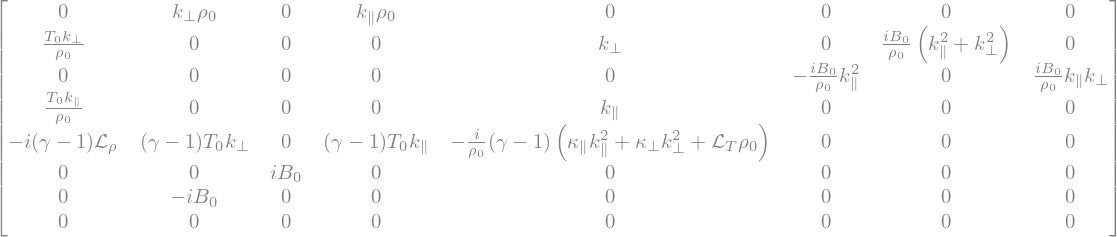

In [10]:
nad_matrix = sp.Matrix([
  [0, k_perp * rho0, 0, k_para * rho0, 0, 0, 0, 0],
  [T0 * k_perp / rho0, 0, 0, 0, k_perp, 0, sp.I * b0 / rho0 * (k_para**2+k_perp**2), 0],
  [0, 0, 0, 0, 0, -sp.I * b0 * k_para**2 / rho0, 0, sp.I * b0 * k_para * k_perp / rho0],
  [T0 * k_para / rho0, 0, 0, 0, k_para, 0, 0, 0],
  [
    -sp.I * gmone * Lrho, 
    gmone * T0 * k_perp, 
    0, 
    gmone * T0 * k_para, 
    -sp.I * gmone * (
      kappa_para * k_para**2 + kappa_perp * k_perp**2 + rho0 * LT
    ) / rho0, 
    0, 
    0, 
    0
  ],
  [0, 0, sp.I * b0, 0, 0, 0, 0, 0],
  [0, -sp.I * b0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0]
])
display(nad_matrix)

In [11]:
def get_numerical_matrix(rho0val, T0val, b0val, k_perpval, k_paraval, curves):
  matrix = nad_matrix.subs(gmone, 5/3 - 1)
  tcpara, tcperp = get_conduction_coeffs(rho0val, T0val, b0val)
  LTval, Lrhoval = get_heatloss_values(curves, T0val, rho0val)
  matrix = matrix.subs({
    kappa_para: tcpara,
    kappa_perp: tcperp,
    Lrho: Lrhoval,
    LT: LTval,
  })

  numerical_matrix = sp.lambdify((rho0, T0, b0, k_perp, k_para), matrix, "numpy")
  return numerical_matrix(rho0val, T0val, b0val, k_perpval, k_paraval)

In [13]:
def extract_slow_thermal_solutions(solutions):
  if len(solutions) != 3:
    raise ValueError
  # create mask for purely imaginary solutions
  mask = np.isclose(abs(solutions.real), 0)
  # this should only have 1 True element, the thermal solution
  if np.count_nonzero(mask) == 1:
      s_neg, s_pos = np.sort_complex(solutions[np.invert(mask)])
  else:
      mask = np.array([False] * 3, dtype=bool)
      mask[solutions.imag.argmax()] = True
      s_neg, s_pos = np.sort_complex(solutions[np.invert(mask)])
  (wth,) = solutions[mask]
  wsmin = s_neg
  wsplus = s_pos
  return wth, wsmin, wsplus

In [14]:
def get_eigenvalues(rho0val, T0val, b0val, k_perpval, k_paraval, curves):
  eigvals = np.linalg.eigvals(
    get_numerical_matrix(
      rho0val=rho0val, 
      T0val=T0val, 
      b0val=b0val, 
      k_perpval=k_perpval, 
      k_paraval=k_paraval,
      curves=curves,
    )
  )
  # remove spurious zero solution
  eigvals = np.sort_complex(eigvals[abs(eigvals) > 1e-12])
  # extract alfven modes
  wa = -b0val * k_paraval / np.sqrt(rho0val)
  wa_min_idx = np.argmin(abs(eigvals.real - wa))
  wa_plus_idx = np.argmin(abs(eigvals.real + wa))
  eigvals = np.delete(eigvals, [wa_min_idx, wa_plus_idx])
  eigvals = np.sort_complex(eigvals)
  # extract thermal and slow modes
  wth, wsmin, wsplus = extract_slow_thermal_solutions(eigvals[1:4])
  solutions = {
    "fast-": eigvals[0],
    "alfven-": -wa,
    "slow-": wsmin,
    "thermal": wth,
    "slow+": wsplus,
    "alfven+": wa,
    "fast+": eigvals[-1]
  }
  # sanity checks
  if abs(solutions["thermal"].real) > 1e-12:
    print(f"temperature: {T0val}")
    print(T0val)
    print(eigvals)
    print("-"*50)
    raise ValueError(f"Thermal mode is not imaginary! {solutions}")
  if abs(solutions["alfven-"].imag) > 1e-12 or abs(solutions["alfven+"].imag) > 1e-12:
    print(f"temperature: {T0val}")
    print(eigvals)
    print("-"*50)
    raise ValueError(f"Alfven modes are not real! {solutions}")
  return solutions

In [15]:
# growth rates plot
fastsols_spex, slowsols_spex, thermalsols_spex = [], [], []
fastsols_jc, slowsols_jc, thermalsols_jc = [], [], []

T0range = np.logspace(3, 7, 500)
for tempval in T0range:
  magfield = 10 / ds.units["unit_magneticfield"]
  temperature = tempval / ds.units["unit_temperature"]
  solutions_spex = get_eigenvalues(
    rho0val=1, 
    T0val=temperature, 
    b0val=magfield, 
    k_perpval=0.5, 
    k_paraval=0.5,
    curves=curves_spex,
  )
  solutions_jc = get_eigenvalues(
    rho0val=1,
    T0val=temperature,
    b0val=magfield,
    k_perpval=0.5,
    k_paraval=0.5,
    curves=curves_jc,
  )
  fastsols_spex.append(solutions_spex["fast+"].imag)
  slowsols_spex.append(solutions_spex["slow+"].imag)
  thermalsols_spex.append(solutions_spex["thermal"].imag)

  fastsols_jc.append(solutions_jc["fast+"].imag)
  slowsols_jc.append(solutions_jc["slow+"].imag)
  thermalsols_jc.append(solutions_jc["thermal"].imag)


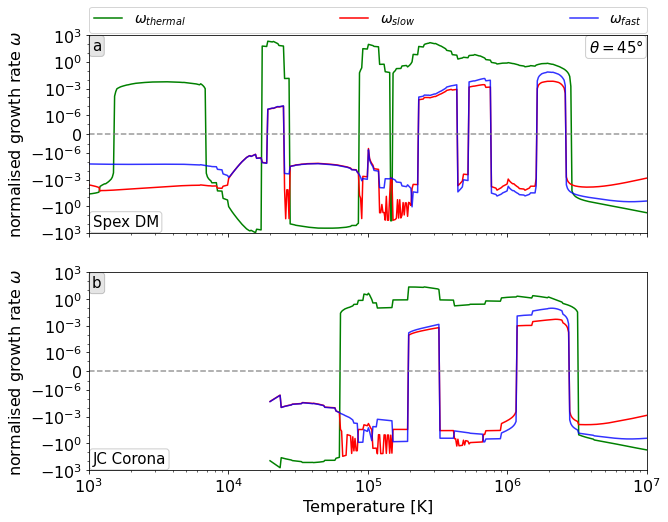

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex="all")
ax1, ax2 = axes.flatten()

ax1.semilogx(T0range, thermalsols_spex, "-g", label=thermallabel)
ax1.semilogx(T0range, slowsols_spex, "-r", label=slowlabel)
ax1.semilogx(T0range, fastsols_spex, "-b", label=fastlabel, alpha=0.8)

jc_cutoff = 2e4
jc_cutoff_idx = np.argmin(abs(T0range - jc_cutoff))
ax2.semilogx(T0range[jc_cutoff_idx::], thermalsols_jc[jc_cutoff_idx::], "-g")
ax2.semilogx(T0range[jc_cutoff_idx::], slowsols_jc[jc_cutoff_idx::], "-r")
ax2.semilogx(T0range[jc_cutoff_idx::], fastsols_jc[jc_cutoff_idx::], "-b", alpha=0.8)

ax1.legend(
  bbox_to_anchor=(0.0, 1.01, 1, 0.102),
  loc="lower left",
  ncol=3,
  mode="expand",
  borderaxespad=0,
)
ax2.set_xlim(T0range[0], T0range[-1])
ax2.set_xlabel("Temperature [K]")

for ax in axes:
  ax.set_ylabel("normalised growth rate $\omega$")
  ax.axhline(y=0, linestyle="dashed", alpha=0.8, color="grey")
  ax.set_yscale("symlog", linthresh=1e-7)
  ax.set_yticks([-1e3, -1e0, -1e-3, -1e-6, 0, 1e-6, 1e-3, 1e0, 1e3])

add_panel_label(ax1, "a", loc="top left")
add_panel_label(ax1, "Spex DM", loc="bottom left", color="none")
add_panel_label(ax2, "b", loc="top left")
add_panel_label(ax2, "JC Corona", loc="bottom left", color="none")
add_panel_label(ax1, r"$\theta = 45\degree$", loc="top right", color="none")

fig.savefig(
  "../03-thermal_instability/figures/coolcurve_comparison.png", 
  bbox_inches="tight", 
  dpi=400,
)

plt.show()


In [ ]:
magfield = 10 / ds.units["unit_magneticfield"]
temperature = 1e5 / ds.units["unit_temperature"]
solutions = get_eigenvalues(
  rho0val=1, T0val=temperature, b0val=magfield, k_perpval=0.5, k_paraval=0.5
)
for sol in solutions:
  print(sol, solutions[sol])